# Predict in-game Rank Tetr.io
---
**Por: Ian Joab Padron Corona - A01708940**

<a href="https://colab.research.google.com/github/Ian326/TC3002B/blob/main/Code/TetrisRankPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Librerias

In [1]:
'''
===============================================================================
Librerias de Python a utilizar en el proyecto
===============================================================================
pandas: Libreria de manipulacion de datos en DataFrames
numpy: Libreria para operaciones matematicas y manipulacion de arreglos
seaborn: Libreria para visualizacion de datos
matplotlib: Libreria para graficar
tensorflow: Libreria de aprendizaje profundo
keras: API de alto nivel para crear redes neuronales
Sequential: API para crear modelos de redes neuronales
Dense: Capa densa (fully connected)
OneHotEncoder: Convertir variables categoricas en numericas creando columnas binarias. ESTE SOLO PARA EL DE TETRIS
MinMaxScaler: Normaliza los datos entre 0 y 1
train_test_split: Divide los datos en conjuntos de entrenamiento y prueba
classification_report: Genera un informe de clasificacion
confusion_matrix: Crea una matriz de confusiones
===============================================================================
'''

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

## Datos

In [2]:
# Cargar el dataset
data = pd.read_csv('../content/tl-data-09-2023.csv', low_memory=False)
# Eliminar columnas innecesarias
data.drop(columns=['id', 'username', 'country', 'bestrank', '40l_sprint', 'blitz'], inplace=True)

In [3]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45197 entries, 0 to 45196
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   gamesplayed  45197 non-null  int64  
 1   gameswon     45197 non-null  int64  
 2   tr           45197 non-null  float64
 3   glicko       45197 non-null  float64
 4   rd           45197 non-null  float64
 5   rank         45197 non-null  object 
 6   apm          45197 non-null  float64
 7   pps          45197 non-null  float64
 8   vs           45197 non-null  float64
 9   verified     45197 non-null  bool   
dtypes: bool(1), float64(6), int64(2), object(1)
memory usage: 3.1+ MB
None


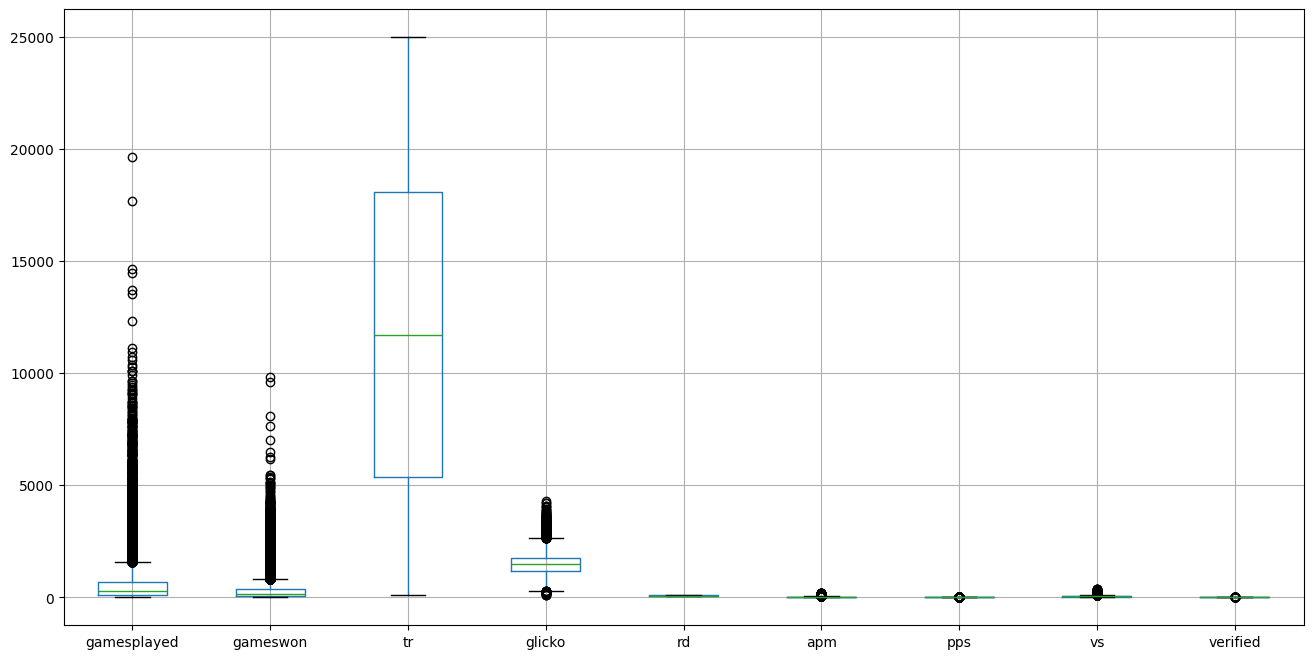

In [4]:
data.boxplot(figsize = (16, 8))
plt.show()

## Escalamiento

In [5]:
# Inicializar el codificador OneHotEncoder
scaler = MinMaxScaler()

data_scaled = data.copy()
# Eliminar la 'target' por ser una variable categorica
rank_column = data_scaled['rank']
data_scaled.drop(columns=['rank'], inplace=True)

# Aplicar MinMaxScaler a las columnas numericas
data_scaled = pd.DataFrame(scaler.fit_transform(data_scaled), columns=data_scaled.columns)

# Reinsertar la columna 'rank' al DataFrame escalado
data_scaled['rank'] = rank_column

del rank_column

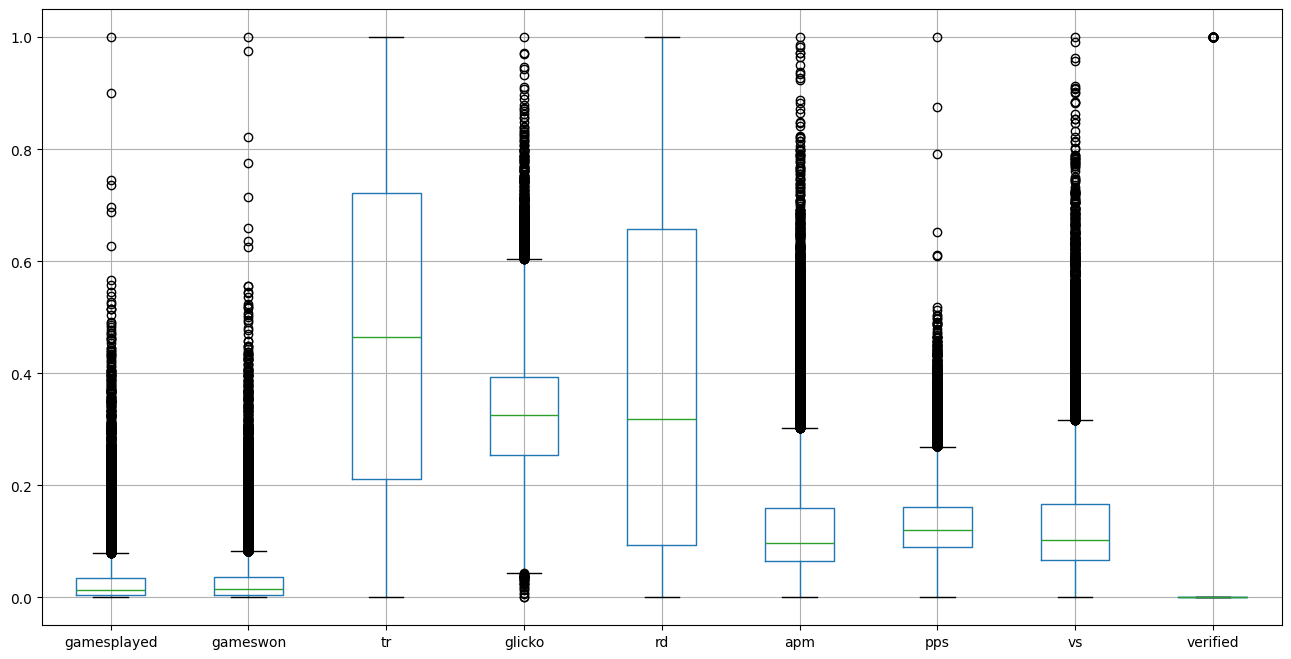

In [6]:
data_scaled.boxplot(figsize = (16, 8))
plt.show()

### OneHotEncoder

In [7]:
# Inicializar el codificador OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Aplicar OneHotEncoder a la columna 'rank'
rank_encoded = encoder.fit_transform(data[['rank']])

# DataFrame con las columnas codificadas
rank_encoded_df = pd.DataFrame(rank_encoded, columns=encoder.get_feature_names_out(['rank']))

rank_columns = rank_encoded_df.columns.tolist()

# Concatenatar el DataFrame original con el DataFrame codificado
data_scaled = pd.concat([data_scaled, rank_encoded_df], axis=1)

# Eliminar la columna 'rank' original del DataFrame escalado. Pues ya no es necesaria
data_scaled = data_scaled.drop(columns=['rank'])

## Separacion

In [8]:
# Asignar las 'features: X' y la 'target variable: y'
X = data_scaled.drop(columns=rank_columns)
y = data_scaled[rank_columns]

# Dividir los datos en en train y test
X_train, X_test, y_train, y_test = train_test_split(
                                                    X,
                                                    y,
                                                    train_size   = 0.80,
                                                    random_state = 42,
                                                    shuffle      = True
                                                    )

## Modelo

### Classifier

In [9]:
def model_simple(shape: tuple):
    """
    Modelo simple de perceptrón multicapa o red neuronal. 

    Parameters
    ---
    shape: `tuple` Dimension de la entrada de la red neuronal.

    Returns
    ---
    model: `keras.Sequential` Modelo de red neuronal secuencial.
    """
    model  =  Sequential([
                    Dense(96, activation='relu', input_shape=shape),
                    Dense(96, activation='relu'),
                    Dense(17, activation='softmax')
            ])
    return model

In [10]:
def compile_model_simple(model) -> None:
    """
    Compila el modelo con un optimizador, una función de pérdida y una métrica.
    Parameters
    ---
    model: `keras.Sequential` Modelo de red neuronal secuencial.

    Returns
    ---
    `None` El modelo se compila y no devuelve nada.
    """
    model.compile(optimizer= "adam",
                  loss = "categorical_crossentropy",
                  metrics=['accuracy'])

In [11]:
def train_model_simple(model, features: pd.DataFrame, labels: pd.DataFrame):
    """
    Entrena el modelo con los datos de entrenamiento y valida con los datos de prueba.

    Parameters
    ---
    model: `keras.Sequential` Modelo de red neuronal secuencial.
    features: `DataFrame` Datos de entrada para el entrenamiento.
    labels: `DataFrame` Etiquetas de salida para el entrenamiento.

    Returns
    ---
    `keras.callbacks.History` Historial del entrenamiento del modelo.
    """
    return model.fit(
                     x=features, 
                     y=labels, 
                     validation_data=(X_test, y_test),
                     epochs = 20)

In [12]:
# Preparar el modelo
model_nn = model_simple(X_train.shape[1:])
model_nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 96)                960       
                                                                 
 dense_1 (Dense)             (None, 96)                9312      
                                                                 
 dense_2 (Dense)             (None, 17)                1649      
                                                                 
Total params: 11,921
Trainable params: 11,921
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Compilar el modelo
compile_model_simple(model_nn)

In [14]:
# Entrenar el modelo
history_nn = train_model_simple(model_nn, X_train, y_train)

Epoch 1/20
1130/1130 [==============================] - 5s 4ms/step - loss: 1.1993 - accuracy: 0.6121 - val_loss: 0.5834 - val_accuracy: 0.7993
Epoch 2/20
1130/1130 [==============================] - 4s 4ms/step - loss: 0.4310 - accuracy: 0.8687 - val_loss: 0.3346 - val_accuracy: 0.8999
Epoch 3/20
1130/1130 [==============================] - 4s 4ms/step - loss: 0.2866 - accuracy: 0.9101 - val_loss: 0.2520 - val_accuracy: 0.9211
Epoch 4/20
1130/1130 [==============================] - 4s 4ms/step - loss: 0.2274 - accuracy: 0.9272 - val_loss: 0.2023 - val_accuracy: 0.9326
Epoch 5/20
1130/1130 [==============================] - 4s 4ms/step - loss: 0.1972 - accuracy: 0.9305 - val_loss: 0.1803 - val_accuracy: 0.9373
Epoch 6/20
1130/1130 [==============================] - 4s 4ms/step - loss: 0.1777 - accuracy: 0.9368 - val_loss: 0.1928 - val_accuracy: 0.9281
Epoch 7/20
1130/1130 [==============================] - 4s 4ms/step - loss: 0.1634 - accuracy: 0.9398 - val_loss: 0.1759 - val_accuracy:

### Plot accuracy

In [15]:
frame_trainingAcc = pd.DataFrame(history_nn.history['accuracy'])
frame_testingAcc = pd.DataFrame(history_nn.history['val_accuracy'])
frame_trainingLoss = pd.DataFrame(history_nn.history['loss'])
frame_testingLoss = pd.DataFrame(history_nn.history['val_loss'])

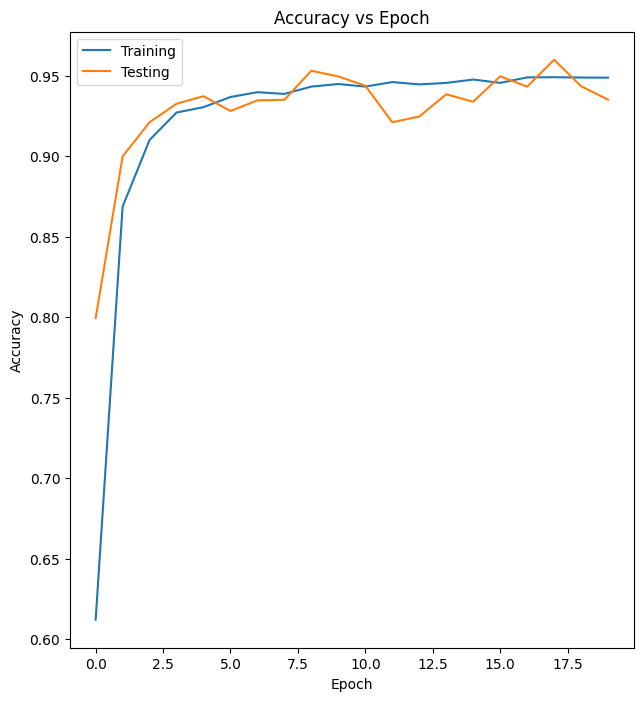

In [16]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.plot(frame_trainingAcc, label='Training')
plt.plot(frame_testingAcc, label='Testing')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

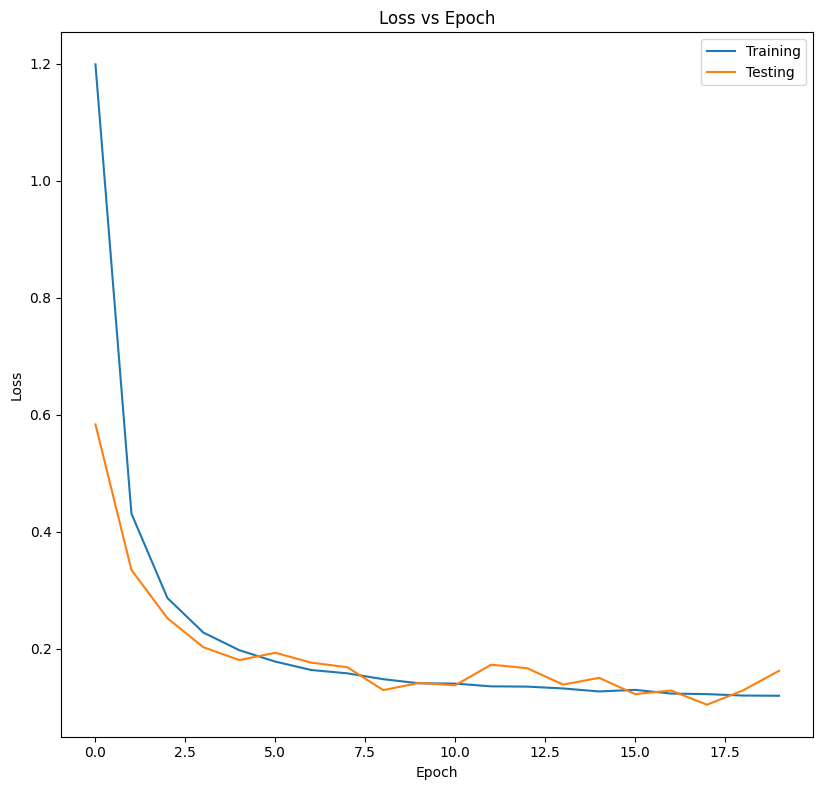

In [17]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 2)
plt.plot(frame_trainingLoss, label='Training')
plt.plot(frame_testingLoss, label='Testing')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Evaluacion

In [18]:
def evaluate_model(model, test_features: pd.DataFrame, test_labels:pd.DataFrame) -> tuple:
    """
    Evalua el modelo de acuerdo a las features y labels de test.
    
    Parameters
    ---
    model: `keras.Sequential` Modelo de red neuronal secuencial.
    test_features: `DataFrame` Datos de entrada para la evaluación.
    test_labels: `DataFrame` Etiquetas de salida para la evaluación.

    Returns
    ---
    test_loss: `float` Pérdida del modelo en el conjunto de prueba.
    test_accuracy: `float` Precisión del modelo en el conjunto de prueba.
    """
    test_loss, test_accuracy = model.evaluate(test_features, test_labels)
    return (test_loss, test_accuracy)

In [19]:
test_loss, test_accuracy = evaluate_model(model_nn, X_test, y_test)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

283/283 [==============================] - 1s 3ms/step - loss: 0.1619 - accuracy: 0.9352
Test loss: 0.1619
Test accuracy: 0.9352


In [20]:
# Predicciones y métricas
preds = model_nn.predict(X_test)
y_pred = np.argmax(preds, axis=1)
y_true = np.argmax(y_test.values, axis=1)
class_labels = list(y_test.columns)

print("\n Reporte de clasificación:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

283/283 [==============================] - 0s 1ms/step

 Reporte de clasificación:

              precision    recall  f1-score   support

      rank_a       0.94      0.91      0.93       694
     rank_a+       0.92      0.92      0.92       706
     rank_a-       0.89      0.95      0.92       762
      rank_b       0.92      0.95      0.94       729
     rank_b+       0.95      0.88      0.91       708
     rank_b-       0.96      0.91      0.94       699
      rank_c       0.99      0.96      0.97       564
     rank_c+       0.97      0.95      0.96       542
     rank_c-       0.97      0.98      0.98       477
      rank_d       1.00      0.90      0.95       237
     rank_d+       0.89      0.97      0.93       238
      rank_s       0.97      0.79      0.87       507
     rank_s+       0.84      0.97      0.90       564
     rank_s-       0.91      0.98      0.94       601
     rank_ss       0.96      0.98      0.97       543
      rank_u       0.96      0.96      0.96       3

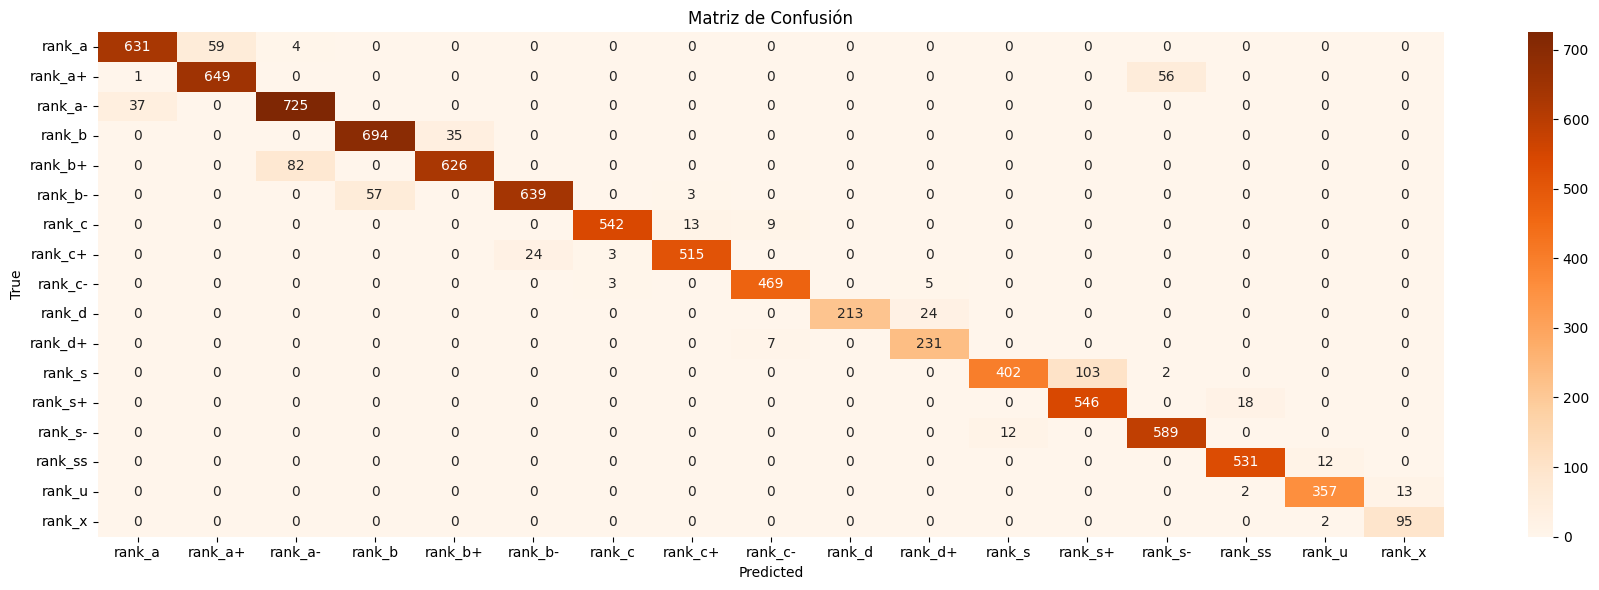

In [21]:
# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(18, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusión')
plt.tight_layout()
plt.show()

# Pruebas en Casos Unitarios

In [22]:
def cleanAPIResponse(df: pd.DataFrame) -> pd.DataFrame:
    """
    Limpia el DataFrame obtenido de la API de acuerdo a las columnas necesarias para el modelo.

    Parameters
    ---

    df: `DataFrame` DataFrame obtenido de los datos de la API.

    Returns
    ---
    df: `DataFrame` DataFrame limpio y preparado para el modelo.
    """

    df.drop(columns=['gxe', 'decaying', 'standing', 'percentile', 'standing_local', 'prev_at', 
                     'next_rank', 'next_at', 'percentile_rank'], inplace=True)
    return df

In [23]:
def prepareUserData(df: pd.DataFrame) -> pd.DataFrame:
    """
    Prepara los datos del usuario para el modelo de acuerdo a las columnas necesarias.

    Parameters
    ---
    df: `DataFrame` DataFrame obtenido de los datos del usuario.

    scaler: `MinMaxScaler` Escalador de datos.

    Returns
    ---
    df: `DataFrame` DataFrame preparado y escalado para el modelo.
    """
    
    # Reordenamiento de las columnas de acuerdo a la estructura del modelo
    reorder_columns = ['gamesplayed', 'gameswon', 'tr', 'glicko', 'rd', 'apm', 'pps', 
                       'vs', 'verified']
    user_data_scaled = df[reorder_columns]

    # Escalamiento de las columnas con MinMaxScaler
    user_data_scaled = pd.DataFrame(scaler.transform(user_data_scaled), 
                                    columns=user_data_scaled.columns)

    return user_data_scaled

In [24]:
import httpx

def searchUser(username:str) -> pd.DataFrame | None:
    """
    Busca el usuario en la API de Tetr.io y devuelve un DataFrame con los datos del usuario.

    Parameters
    ---
    username: `str` Nombre de usuario a buscar.

    Returns
    ---
    df: `DataFrame` DataFrame con los datos del usuario.
    """

    url = f"https://ch.tetr.io/api/users/{username}/summaries/league"
    
    headers = {
        "Host": "ch.tetr.io",
        "User-Agent": "Mozilla/5.0",
        "Connection": "keep-alive"
    }

    with httpx.Client(http2=True, timeout=1) as client:
        response = client.get(url, headers=headers)

    if response.status_code == 200:
        response_data = response.json()
        
        if 'data' in response_data:
            user_data = response_data['data']
            user_data.pop("past", None)
            user_data["verified"] = True
            return pd.DataFrame(user_data, index=[0])
        
        else:
            print("No 'data' found for the user.")
            return None
    else:
        print(f"Failed to fetch data. Status code: {response.status_code}")
        return None

In [25]:
def getUserRank():
    """
    Obtiene informacion del usuario a partir de la API de Tetr.io y predice su rango utilizando el modelo entrenado.
    """
    
    userName = input("Enter the player's username: ")
    user_data = searchUser(userName)

    if user_data is not None:
        
        # Guardar el rango del usuario antes de eliminar la columna
        user_rank = user_data['rank']
        user_data.drop(columns=['rank'], inplace=True)

        # Limpiar y preparar los datos del usuario
        user_data = prepareUserData(user_data)

        # Predecir el rango del usuario utilizando el modelo entrenado
        prediction = model_nn.predict(user_data)
        
        # Decodificar la predicción para obtener el índice de la clase
        predicted_class = np.argmax(prediction, axis=1)
        
        # Mapear el índice de la clase a la etiqueta de rango correspondiente
        predicted_rank = rank_columns[predicted_class[0]]
        
        print(f"The predicted rank for user '{userName}' is: {predicted_rank}")
        print(f"The factual rank for user '{userName}' is: rank_{user_rank.values[0]}")
        
    else:
        print(f"Failed to retrieve data for user {userName}.")

In [26]:
getUserRank()

1/1 [==============================] - 0s 19ms/step
The predicted rank for user 'tanielpoto' is: rank_c
The factual rank for user 'tanielpoto' is: rank_c
